In [0]:
import numpy as np
import pickle
import os
import urllib
import zipfile 
import tarfile
from six.moves import urllib

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# tensorflow imports
import tensorflow as tf
from tensorflow.contrib.training import HParams

# tf.keras imports
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization, AveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# import for showing the confusion matrix
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [0]:
hparams = HParams(
    n_classes=10,  # number of different classes in dataset
    learning_rate=1e-4,  # fixed learning rate
    train_batch_size=32,  # training batch size
    val_batch_size=32,  # validation batch size
    test_batch_size=32,  # testing batch size
    n_epochs=10,  # number of epochs to train
    input_name='input_1',  # name of the input tensor for first layer of Keras model
    data_dir='/tmp/cifar-data/',  # path to data directory
    checkpoint_dir='/tmp/checkpoints/'  # path to model checkpoint directory
)

In [4]:
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip -o ngrok-stable-linux-amd64.zip

--2019-10-14 19:39:27--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.3.53.115, 34.196.216.163, 52.204.38.150, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.3.53.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  31.0MB/s    in 0.4s    

2019-10-14 19:39:28 (31.0 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [5]:
import os
import pprint
import tensorflow as tf

if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

TPU address is grpc://10.122.57.234:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 17000014224146503991),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 15596874545428975312),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 8098472124029523425),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 12066745907509952555),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 6702596531973209726),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 6798188185226095051),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 156870001089814519),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 15629259245018844438),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 253447043060

In [6]:
# kill all running ngrok instances
!pkill -f ngrok

# Execute tensorboard
!rm rf /tmp/checkpoints
!mkdir /tmp/checkpoints
LOG_DIR = '/tmp/checkpoints/'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

# execute ngrok
get_ipython().system_raw('./ngrok http 6006 &')

rm: cannot remove 'rf': No such file or directory
rm: cannot remove '/tmp/checkpoints': No such file or directory


In [7]:
# Do the tunneling
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://e92dc435.ngrok.io


In [0]:
# URL for the data-set on the internet.
data_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

# Width and height of each image.
img_size = 32

# Number of channels in each image, 3 channels: Red, Green, Blue.
num_channels = 3

# Length of an image when flattened to a 1-dim array.
img_size_flat = img_size * img_size * num_channels

# Number of classes.
num_classes = hparams.n_classes

########################################################################
# Various constants used to allocate arrays of the correct size.

# Number of files for the training-set.
_num_files_train = 5

# Number of images for each batch-file in the training-set.
_images_per_file = 10000

# Total number of images in the training-set.
# This is used to pre-allocate arrays for efficiency.
_num_images_train = _num_files_train * _images_per_file

########################################################################
# Private functions for downloading, unpacking and loading data-files.


def download(base_url, filename, download_dir):
    """
    Download the given file if it does not already exist in the download_dir.
    :param base_url: The internet URL without the filename.
    :param filename: The filename that will be added to the base_url.
    :param download_dir: Local directory for storing the file.
    :return: Nothing.
    """

    # Path for local file.
    save_path = os.path.join(download_dir, filename)

    # Check if the file already exists, otherwise we need to download it now.
    if not os.path.exists(save_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        print("Downloading", filename, "...")

        # Download the file from the internet.
        url = base_url + filename
        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=save_path)

        print(" Done!")


def maybe_download_and_extract(url=data_url, download_dir=hparams.data_dir):
    """
    Download and extract the data if it doesn't already exist.
    Assumes the url is a tar-ball file.
    :param url:
        Internet URL for the tar-file to download.
        Example: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    :param download_dir:
        Directory where the downloaded file is saved.
        Example: "data/CIFAR-10/"
    :return:
        Nothing.
    """

    # Filename for saving the file downloaded from the internet.
    # Use the filename from the URL and add it to the download_dir.
    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)

    # Check if the file already exists.
    # If it exists then we assume it has also been extracted,
    # otherwise we need to download and extract it now.
    if not os.path.exists(file_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        # Download the file from the internet.
        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=file_path)

        print()
        print("Download finished. Extracting files.")

        if file_path.endswith(".zip"):
            # Unpack the zip-file.
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
        elif file_path.endswith((".tar.gz", ".tgz")):
            # Unpack the tar-ball.
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done.")
    else:
        print("Data has apparently already been downloaded and unpacked.")


def _get_file_path(filename=""):
    """
    Return the full path of a data-file for the data-set.

    If filename=="" then return the directory of the files.
    """

    return os.path.join(hparams.data_dir, "cifar-10-batches-py/", filename)


def _unpickle(filename):
    """
    Unpickle the given file and return the data.

    Note that the appropriate dir-name is prepended the filename.
    """

    # Create full path for the file.
    file_path = _get_file_path(filename)

    print("Loading data: " + file_path)

    with open(file_path, mode='rb') as file:
        # In Python 3.X it is important to set the encoding,
        # otherwise an exception is raised here.
        data = pickle.load(file,encoding='bytes')

    return data


def _convert_images(raw):
    """
    Convert images from the CIFAR-10 format and
    return a 4-dim array with shape: [image_number, height, width, channel]
    where the pixels are floats between 0.0 and 1.0.
    """

    # Convert the raw images from the data-files to floating-points.
    raw_float = np.array(raw, dtype=float) / 255.0

    # Reshape the array to 4-dimensions.
    images = raw_float.reshape([-1, num_channels, img_size, img_size])

    # Reorder the indices of the array.
    images = images.transpose([0, 2, 3, 1])

    return images


def _load_data(filename):
    """
    Load a pickled data-file from the CIFAR-10 data-set
    and return the converted images (see above) and the class-number
    for each image.
    """

    # Load the pickled data-file.
    data = _unpickle(filename)

    # Get the raw images.
    raw_images = data[b'data']

    # Get the class-numbers for each image. Convert to numpy-array.
    cls = np.array(data[b'labels'])

    # Convert the images.
    images = _convert_images(raw_images)

    return images, cls


def load_class_names():
    # Load the class-names from the pickled file.
    raw = _unpickle(filename="batches.meta")[b'label_names']

    # Convert from binary strings.
    names = [x.decode('utf-8') for x in raw]

    return names


def load_training_data():
    """
    Load all the training-data for the CIFAR-10 data-set.

    The data-set is split into 5 data-files which are merged here.

    Returns the images, class-numbers and one-hot encoded class-labels.
    """

    # Pre-allocate the arrays for the images and class-numbers for efficiency.
    images = np.zeros(shape=[_num_images_train, img_size, img_size, num_channels], dtype=float)
    cls = np.zeros(shape=[_num_images_train], dtype=int)

    # Begin-index for the current batch.
    begin = 0

    # For each data-file.
    for i in range(_num_files_train):
        # Load the images and class-numbers from the data-file.
        images_batch, cls_batch = _load_data(filename="data_batch_" + str(i + 1))

        # Number of images in this batch.
        num_images = len(images_batch)

        # End-index for the current batch.
        end = begin + num_images

        # Store the images into the array.
        images[begin:end, :] = images_batch

        # Store the class-numbers into the array.
        cls[begin:end] = cls_batch

        # The begin-index for the next batch is the current end-index.
        begin = end

    return images, cls


def load_validation_data():

    images, cls = _load_data(filename="test_batch")

    images = images[5000:, :, :, :]
    cls = cls[5000:]

    return images, cls

def load_testing_data():


    images, cls = _load_data(filename="test_batch")

    images = images[:5000, :, :, :]
    cls = cls[:5000]

    return images, cls

In [9]:
import matplotlib.pyplot as plt
maybe_download_and_extract()
x_val, y_val = load_validation_data()


Download finished. Extracting files.
Done.
Loading data: /tmp/cifar-data/cifar-10-batches-py/test_batch


In [10]:
x_val.shape

(5000, 32, 32, 3)

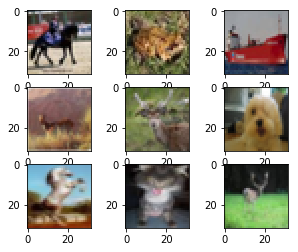

In [11]:
fig = plt.figure(figsize=(5,4))
for i in range(3):
    for j in range(3):
        ax = fig.add_subplot(3, 3, i * 3 + j + 1)
        ax.imshow(x_val[i * 3 + j])

In [0]:
from tensorflow.keras.layers import MaxPooling2D


In [0]:
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.regularizers import l2

In [0]:
def get_model():
    
    model = tf.keras.models.Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(32, 32, 3), activation='elu'))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='elu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(units=512, activation='elu'))
    model.add(Dense(units=128, activation='elu'))
    model.add(Dense(units=32, activation='elu'))
    model.add(Dense(units=10, activation='elu'))
    
    model.add(Dense(units=10, activation='softmax'))
    
    print('Model initialized. Please compile before training.')
    
    return model

In [0]:
# Hyperparameters

batch_size = 128
epochs = 50

In [48]:
model_sgd_plain = get_model()

Model initialized. Please compile before training.


In [51]:
model_sgd_plain.summary()
sgd_plain = Adamax(learning_rate=hparams.learning_rate)
model_sgd_plain.compile(loss='sparse_categorical_crossentropy', optimizer=sgd_plain, metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)             

In [0]:
tf.logging.set_verbosity(tf.logging.DEBUG)

In [15]:
# training data
x_train, y_train = load_training_data()

# Validation data
x_val, y_val = load_validation_data()

# Testing data
x_test, y_test = load_testing_data()

# Define callbacks
callbacks = [
  tf.keras.callbacks.TensorBoard(log_dir=hparams.checkpoint_dir)
]

Loading data: /tmp/cifar-data/cifar-10-batches-py/data_batch_1
Loading data: /tmp/cifar-data/cifar-10-batches-py/data_batch_2
Loading data: /tmp/cifar-data/cifar-10-batches-py/data_batch_3
Loading data: /tmp/cifar-data/cifar-10-batches-py/data_batch_4
Loading data: /tmp/cifar-data/cifar-10-batches-py/data_batch_5
Loading data: /tmp/cifar-data/cifar-10-batches-py/test_batch
Loading data: /tmp/cifar-data/cifar-10-batches-py/test_batch


In [0]:
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    zca_epsilon=1e-06,  # epsilon for ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.1,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.1,
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    cval=0.,  # value used for fill_mode = "constant"
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)


In [56]:
#model_sgd_plain.fit_generator( datagen.flow(x_train, y_train,batch_size=hparams.train_batch_size), epochs=hparams.n_epochs,
    #validation_data=(x_val, y_val), callbacks=callbacks)


Epoch 1/10
1563/1563 [==============================] - 256s 164ms/step - loss: 1.6651 - acc: 0.4036 - val_loss: 1.5409 - val_acc: 0.4492
Epoch 2/10
1563/1563 [==============================] - 255s 163ms/step - loss: 1.5645 - acc: 0.4422 - val_loss: 1.4675 - val_acc: 0.4736
Epoch 3/10
1563/1563 [==============================] - 251s 160ms/step - loss: 1.4961 - acc: 0.4692 - val_loss: 1.5101 - val_acc: 0.4622
Epoch 4/10
1563/1563 [==============================] - 250s 160ms/step - loss: 1.4478 - acc: 0.4896 - val_loss: 1.3772 - val_acc: 0.5088
Epoch 5/10
1563/1563 [==============================] - 252s 161ms/step - loss: 1.4051 - acc: 0.5038 - val_loss: 1.3411 - val_acc: 0.5224
Epoch 6/10
1563/1563 [==============================] - 258s 165ms/step - loss: 1.3604 - acc: 0.5206 - val_loss: 1.3220 - val_acc: 0.5362
Epoch 7/10
1563/1563 [==============================] - 260s 166ms/step - loss: 1.3216 - acc: 0.5341 - val_loss: 1.3109 - val_acc: 0.5396
Epoch 8/10
1563/1563 [============

In [0]:
from tensorflow.keras.layers import Activation, Dropout

In [0]:
wtDecay = 1e-4
def get_model():
    
    model = tf.keras.models.Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=(32, 32, 3), activation='elu', kernel_regularizer= l2(1e-4)))
    #model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), padding='same', activation='elu', kernel_regularizer=l2(wtDecay)))
    #model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3,3), padding='same', activation='elu', kernel_regularizer= l2(wtDecay)))
    #model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), padding='same', activation='elu', kernel_regularizer= l2(wtDecay)))
    #model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (3,3), padding='same', activation='elu', kernel_regularizer= l2(wtDecay)))
    #model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), padding='same', activation='elu', kernel_regularizer= l2(wtDecay)))
    #model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
 
    
    print('Model initialized. Please compile before training.')
    
    return model

In [0]:
# Hyperparameters
hparams = HParams(
    n_classes=10,  # number of different classes in dataset
    learning_rate=1e-3,  # fixed learning rate
    train_batch_size=128,  # training batch size
    val_batch_size=128,  # validation batch size
    test_batch_size=128,  # testing batch size
    n_epochs=30,  # number of epochs to train
    input_name='input_1',  # name of the input tensor for first layer of Keras model
    data_dir='/tmp/cifar-data/',  # path to data directory
    checkpoint_dir='/tmp/checkpoints/'  # path to model checkpoint directory
)

In [21]:
modelAdamax = get_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model initialized. Please compile before training.


In [22]:
modelAdamax.summary()
adamaxPlain = Adamax(learning_rate=hparams.learning_rate)
modelAdamax.compile(loss='sparse_categorical_crossentropy', optimizer=adamaxPlain, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

In [0]:
datagen.fit(x_train)

In [24]:
historyAdamax= modelAdamax.fit_generator(
    datagen.flow(x_train, y_train,batch_size=hparams.train_batch_size),
    epochs=hparams.n_epochs,
    validation_data=(x_val, y_val),
    callbacks=callbacks)


Epoch 1/30
391/391 [==============================] - 563s 1s/step - loss: 2.0732 - acc: 0.3665 - val_loss: 2.2071 - val_acc: 0.3132
Epoch 2/30
391/391 [==============================] - 560s 1s/step - loss: 1.5488 - acc: 0.4876 - val_loss: 1.4393 - val_acc: 0.5380
Epoch 3/30
391/391 [==============================] - 564s 1s/step - loss: 1.3045 - acc: 0.5623 - val_loss: 1.1101 - val_acc: 0.6372
Epoch 4/30
391/391 [==============================] - 559s 1s/step - loss: 1.1565 - acc: 0.6109 - val_loss: 1.1174 - val_acc: 0.6306
Epoch 5/30
391/391 [==============================] - 553s 1s/step - loss: 1.0513 - acc: 0.6449 - val_loss: 1.0317 - val_acc: 0.6806
Epoch 6/30
391/391 [==============================] - 550s 1s/step - loss: 0.9781 - acc: 0.6727 - val_loss: 1.0264 - val_acc: 0.6668
Epoch 7/30
391/391 [==============================] - 553s 1s/step - loss: 0.9200 - acc: 0.6920 - val_loss: 0.9633 - val_acc: 0.6872
Epoch 8/30
391/391 [==============================] - 552s 1s/step - 

In [0]:
# 
plt.plot( historyAdamax.history['acc'])
plt.plot( historyAdamax.history['val_acc'])
plt.title('SGD - Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
#plt.savefig('SGD-Accuracy.jpg')
plt.show()

print()
print()

plt.plot( historyAdamax.history['loss'])
plt.plot( historyAdamax.history['val_loss'])
plt.title('SGD - Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
#plt.savefig('SGD-Loss.jpg')
plt.show()


In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[418  11  10   0   2   2   3   3  24  15]
 [  2 473   0   1   1   0   0   0   5  23]
 [ 26   0 348  12  37  22  37  10   9  11]
 [ 12   2  10 327  29  57  32  13   5  10]
 [  4   2   8   8 440   9  19  13   3   1]
 [  9   2   8  37  20 382  10  14   1   5]
 [  5   4   7  15   7   1 444   3   3   2]
 [  5   0   1   8   9  15   5 447   2   3]
 [ 16   5   0   0   1   0   4   2 464  12]
 [ 11  14   1   0   2   0   0   0   6 479]]


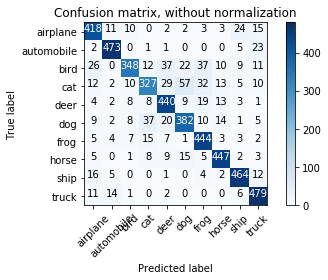

In [26]:
results = modelAdamax.predict(x_test, batch_size=hparams.test_batch_size)

# convert from class probabilities to actual class predictions
predicted_classes = np.argmax(results, axis=1)

# Names of predicted classes
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Generate the confusion matrix
cnf_matrix = confusion_matrix(y_test, predicted_classes)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.show()

In [27]:
print("Test Accuracy: %.2f%%" % (sum(y_test == predicted_classes) * 100. / y_test.shape[0]))

Test Accuracy: 84.44%


In [0]:
plt.plot(history_adam.history['acc'])